In [69]:
from NumericalModel import NumericalModel
from PDFatigueModel import FatigueInputData, PDFatigueSolver
import numpy as np
import matplotlib.pyplot as plt
import pddopyW2 as pddo

## "NumericalModel" class
The "NumericalModel" type is somprised of so called "modules". These modules are
1. Geometry module          ->  NumericalModel.Geometry
2. Discretisations module   ->  NumericalModel.Discretisations
3. Materials module         ->  NumericalModel.Materials
4. Interactions module      ->  NumericalModel.Interactions

Each module has its own main class with the same name as the module.\
The module itself (as in the file where the code is stored) is named with NON-prime letters, while the class inside is primed!

To explain this further it is shown below that the class from each module is imported into the "NumericalModel" type in the following way:

class NumericalModel(): 

    def __init__(self,name: str = "Model") -> None:
        self.name = name
        self.Geometry = geometry.Geometry()
        self.Materials= material.Materials()
        self.Loads = loads.BoundaryCons()
        self.Discretizations = disretization.Discretizations()
        self.Interactions = interactions.Interactions()
        self.SimulationSettings = simulation_settings.SimulationSettings()

This way, when we call a module in the "NumericalModel" instance we directly call the main class if the module with the same name.\
Each of the module classes will be explained during their use!

## Create a "NumericalModel" instance

In [70]:
# Create a NumericalModel
model0 = NumericalModel()

## Geometry module

The geometry module is meant to hold the points that define the whole model. Each point is created as a "PartNodes" type and is saved in the "part_nodes: PartNodes" attribute of the Geometry class.\
The "PartNodes" class is simply a dictionary (hashTable) of all the points in the points in the model.\
Each point is saved as a "Node" type. This type contains the data of each points such as its ID and coordinates.\
Each "Node" can be searched for in the "part_nodes: PartNodes" attribute, using the nodes ID number.

Currently only one part can be created meaning only one "part_nodes: PartNodes" object which contains the dictionary of "Node"s can exist in a single model.

In [71]:
# To create a PartNodes instance in the Geometry modules, we must first have some point with which we define the models geometry.
# I have used a simple example of a rectangular plate with a hole in the middle.
# The data is read from a txt file that conatins coordinates of each point -> each line index in the txt file represents an ID of a point.
# So the points are wirtten in ascending order in terms of ID!s 
# We also define a "dx" variable which will store the distance between two neighboring points.
# Using this dx we also create an array that stores the are of each point.
coordVec = np.loadtxt(fname= "../Testing input data/SED-interface-coordVec.txt")
dx = coordVec[1,0] - coordVec[0,0] 
nodeVolumes = np.loadtxt(fname= "../Testing input data/SED-interface-volumes.txt")
# inclusionIds = np.loadtxt(fname= "../Testing input data/inclusionPlate-inclusionIds.txt",dtype=np.int64)
# matrixIds = np.loadtxt(fname= "../Testing input data/inclusionPlate-matrixIds.txt",dtype=np.int64)

In [72]:
# To define the geometry od the model, we access the geometry modules method "input_part_nodes"
# This method takes array of points coordinates and an aray of point areas and creates the "PartNodes" instance and saves it in 
# the "part_nodes: PartNodes" attribute of the Geometry class.
model0.Geometry.input_part_nodes(inputCoordinates=coordVec,inputVolumes=nodeVolumes)

In [73]:
# If we now use the "get_part_nodes" method on the "part_nodes" attribute (which is now of type "PartNodes"),
#we can return all the nodes in the model
part_nodes = model0.Geometry.part_nodes.get_part_nodes()
#model0.Geometry.part_nodes.get_part_nodes()

# As we can see, this return the dictionary stored in the "PartNodes" instance.
# The (Key,Value) pairs represent the ID of a node and the node itself (as a type) -> (ID, "Node")

# We can also call a specific node and then its attributes in the following way
part_nodes[0].all_data()


[0, [0.0, 0.0], 1.6324864809713295e-07]

# Data module

The data module is meant to hold general data objects such as sets. It is structured so that we have a "Sets" class that stores many "Set" object instances. Currenlty sets are used only to store ID's as is explained in the following code

In [74]:
# We can also define specific sets of points.
# For example lets create a set for each laoding condition we want tin the model.
# Lets go for a stretch in the y deirection. Both the top and bottom points should be displaced upward and downward respectively.
# Because the point were saved in the txt file in a specific way, we define
totint,totbottom,tottop =9684, 9984, 80601 #number of points in main reagion of plate, number of points in omain and bottom set, total number of internal bottom and top points combined
ndivx,nnum =100, coordVec.shape[0]
# To define a set, we go into the goemtry module and into the "sets: Sets" attribute of the geometry module.
# This attribute is a Sets type which stores a table of all sets in the model. 
# To create a set we call the "create_set()" method of the "Sets" type and input the list of node ID's we want in the set and the sets name!
# changed_top = np.array([range(nnum-3*201,nnum-3*201+50),range(nnum-2*201,nnum-2*201+50),range(nnum-1*201,nnum-1*201+50)],dtype=np.int64).flatten()
model0.Geometry.sets.create_set(np.arange(0,nnum/2,1,dtype=int),setName="botHalf")
model0.Geometry.sets.create_set(np.arange(nnum-nnum/2,nnum,1,dtype=int),setName="topHalf")
# model0.Geometry.sets.create_set(changed_top,setName="TestSet2")

In [75]:
# As can be seen from the code below, "sets" contains multiple "Set" instances. We can access the table of "Set" instances as shown below.
# Each "Set" instance contains the name of the set and the array of ID's of the nodes in the set.
SetIDs = model0.Geometry.sets.setTable["botHalf"].get_data()
SetIDs2 = model0.Geometry.sets.setTable["topHalf"].get_data()
botHalfSet = model0.Geometry.sets.setTable["botHalf"]
topHalfSet = model0.Geometry.sets.setTable["topHalf"]

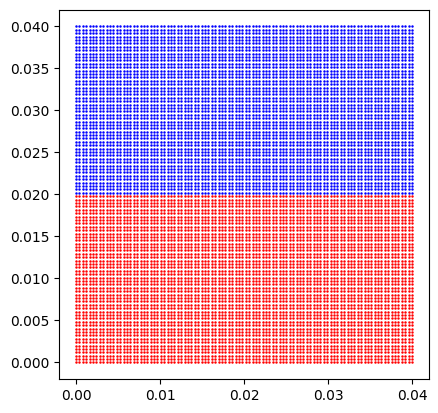

In [76]:
# Graphical representation of the plate with a hole. The blue points are the points in the first set and the red points are from the second set.
fig = plt.figure()
ax = fig.add_subplot()
# ax.scatter(coordVec[:,0],coordVec[:,1],s =1)
ax.scatter(coordVec[SetIDs,0],coordVec[SetIDs,1],s=0.6,c = "r")
ax.scatter(coordVec[SetIDs2,0],coordVec[SetIDs2,1],s=0.6,c = "b")
ax.set_aspect(1)

# Material Module

This module works in mostly the same way as the data module. The  main class is the "Materials" class which lets us create single "Materil" type instances that are then stored in the "Materials" modules "materialTable" dictionary.

In [77]:
model0.Materials.create_material(materialName="Steel1")
model0.Materials.materialsTable["Steel1"].set_tensile_properties(youngMod = 180e9, poisson =0.25)
model0.Materials.materialsTable["Steel1"].get_material_properties()

model0.Materials.create_material(materialName="Steel2")
model0.Materials.materialsTable["Steel2"].set_tensile_properties(youngMod = 180e9, poisson =0.25)
model0.Materials.materialsTable["Steel2"].get_material_properties()

model0.Materials.create_material(materialName="InterfaceSteel")
model0.Materials.materialsTable["InterfaceSteel"].set_tensile_properties(youngMod = 180e9, poisson =0.25)
model0.Materials.materialsTable["InterfaceSteel"].get_material_properties()

steel1 = model0.Materials.materialsTable["Steel1"]
steel1.set_stretch_thresholds(damageInitStretch=0.2, breakageStretch=0.4)
steel2 = model0.Materials.materialsTable["Steel2"]
steel2.set_stretch_thresholds(damageInitStretch=0.4, breakageStretch=0.9)
interface_steel = model0.Materials.materialsTable["InterfaceSteel"]
interface_steel.set_stretch_thresholds(damageInitStretch=0.1, breakageStretch=0.2)

In [78]:
botHalfSet.get_data()

array([   0,    1,    2, ..., 4997, 4998, 4999])

In [79]:
model0.Geometry.sets.create_set(arrayOfIDs=botHalfSet.get_data(), setName = "BotSteel1Section")
model0.Geometry.sets.create_set(arrayOfIDs=topHalfSet.get_data(), setName = "TopSteel2Section")
model0.MaterialSections.create(nodeSet=model0.Geometry.sets.setTable["BotSteel1Section"],material=steel1, name = "Steel1Section")
model0.MaterialSections.create(nodeSet=model0.Geometry.sets.setTable["TopSteel2Section"],material=steel2, name = "Steel2Section")

In [80]:
steel1Section = model0.MaterialSections.materialSectionsTable["Steel1Section"]
steel2Section = model0.MaterialSections.materialSectionsTable["Steel2Section"]

In [81]:
model0.MaterialInterfaces.create(materialSection1=steel1Section,materialSection2=steel2Section,material=interface_steel)

# Discretisaton module

Again... we have a main "Discretisations" class through which we create single "Discretisation" type instances. 

In [82]:
model0.Discretizations.create_discretization("TestDisc")

In [83]:
model0.Discretizations.discretizationsTable["TestDisc"].set_horizon(6*dx)
# model0.Discretizations.discretizationsTable["TestDisc"].create_crack(p1x = -0.01123,p2x = 0.009901,p1y = 0.0101123,p2y = 0.0101123)
model0.Discretizations.discretizationsTable["TestDisc"].generate_bonds(partNodes = model0.Geometry.part_nodes)

the area: [1.63248648e-07 1.63248648e-07 1.63248648e-07 ... 1.63248648e-07
 1.63248648e-07 1.63248648e-07]


In [84]:
# model0.Discretizations.discretizationsTable["TestDisc"].initialCracks

In [85]:
model0.Discretizations.discretizationsTable["TestDisc"].is_crack_active()

False

In [86]:
testDisc = model0.Discretizations.discretizationsTable["TestDisc"]
model0.Discretizations.set_selected_discretization(DiscretizationName="TestDisc")

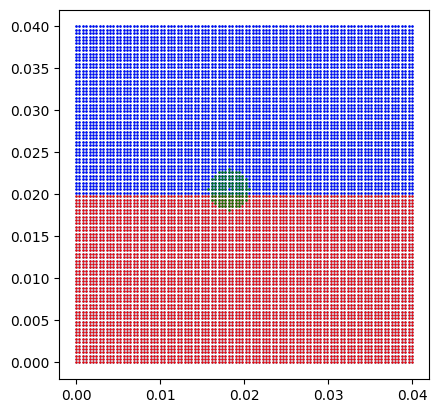

In [87]:
data = testDisc.get_node_family_coords(5145)
fig = plt.figure()
ax = fig.add_subplot()
size=0.5
ax.scatter(coordVec[:,0],coordVec[:,1],s = size)
ax.scatter(coordVec[SetIDs,0],coordVec[SetIDs,1],c = "r",s=size)
ax.scatter(coordVec[SetIDs2,0],coordVec[SetIDs2,1],c = "b",s=size)
ax.scatter(data[:,0],data[:,1],s=size,c="green")
ax.set_aspect(1)
# plt.xlim(0.035,0.04)
# plt.ylim(0.0,0.0024)

# Loads module

In [88]:
#Not needed since i want to apply a uniform displacement field
# model0.Loads.create_disp_load(nodeSet = botFixSet,dispX = 0.0, dispY= -0.002, name="BottomFixture")
# model0.Loads.create_disp_load(nodeSet = topFixSet,dispX = 0.0, dispY=  0.002, name="TopFixture")

In [89]:
# I do need to create the vector for all displacements though
# y(x) = (1 + eps) + x ; x -> point before defomration, y -> point after deformation
eps = 0.05
displaced_coordVec = (1+eps) * coordVec
disps = displaced_coordVec - coordVec

# PDFatigueModel

In [90]:
fatigueModelData = FatigueInputData(numModel = model0)

In [91]:
lines = np.zeros(shape=(testDisc.neighbors.shape[0],4))
for point in range(coordVec.shape[0]):
    for bond in range(testDisc.start_idx[point],testDisc.end_idx[point]):
        j_point_id = testDisc.neighbors[bond]
        lines[bond,0] = coordVec[point,0]
        lines[bond,1] = coordVec[point,1]
        lines[bond,2] = coordVec[j_point_id,0]
        lines[bond,3] = coordVec[j_point_id,1]

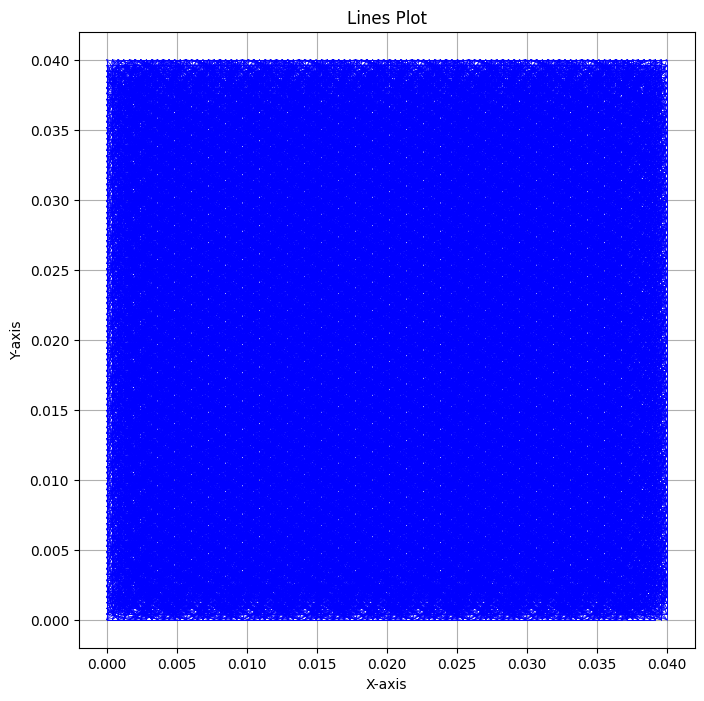

In [92]:
import matplotlib.pyplot as plt
import matplotlib

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 8))
# Loop through each line and plot it
for line in range(lines.shape[0]):
    if line%50 == 0:
        if fatigueModelData.bondMaterialIDarray[line] == 0:
            color = "g"
            linewidth = 0.1
        elif fatigueModelData.bondMaterialIDarray[line] == 1:
            color = "r"
            linewidth = 0.1
        elif fatigueModelData.bondMaterialIDarray[line] == 2:
            color = "k"
            linewidth = 0.1
        else:
            color = "b"
            linewidth = 0.5
    # Extract x and y coordinates for the line
        x_values = [lines[line,0],lines[line,2]]
        y_values = [lines[line,1],lines[line,3]]

    # Plot the line
        ax.plot(x_values, y_values,linewidth = linewidth, c=color)

ax.set_aspect(1)
# Set plot title and labels
plt.title('Lines Plot')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.gca().set_aspect(1)
# Display the plot
plt.grid(True)


In [93]:
solver = PDFatigueSolver(numModel=model0)
forceDensVec = solver.solve_lin_sys(disps = disps.flatten())

In [94]:
# disp = solver.result
# coordVecNew4 = coordVec + disp
coordVecNew4 = displaced_coordVec
disp = disps

In [95]:
bond_stifnesses = solver.gen_bond_stiffness_matrices()
bond_displacement_diff = solver.gen_bond_displacement_vecs(disps)
force_dens_vecs = pddo.generate_force_dens_vecs(bond_stifnesses,bond_displacement_diff)
bond_lens = pddo.calc_bondLenghts(solver.FID.coordVec,solver.FID.neighbors,solver.FID.start_idx,solver.FID.end_idx)
bond_len_change = solver.calc_bond_stretches(coordVecNew4) * bond_lens
bond_micro_potentials = np.linalg.norm(force_dens_vecs,axis=1) * bond_len_change /2
point_SED = pddo.family_integration(solver.FID.neighbors,solver.FID.start_idx,solver.FID.end_idx,bond_micro_potentials,solver.FID.ptVolumes)/2

/var/folders/8j/npxcdjb14wj91z_mr0j6yl8w0000gn/T/ipykernel_26078/3810732878.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('RdYlBu')
/var/folders/8j/npxcdjb14wj91z_mr0j6yl8w0000gn/T/ipykernel_26078/3810732878.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('RdYlBu')
/var/folders/8j/npxcdjb14wj91z_mr0j6yl8w0000gn/T/ipykernel_26078/3810732878.py:73: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm2 = plt.cm.get_cmap('RdYlBu')

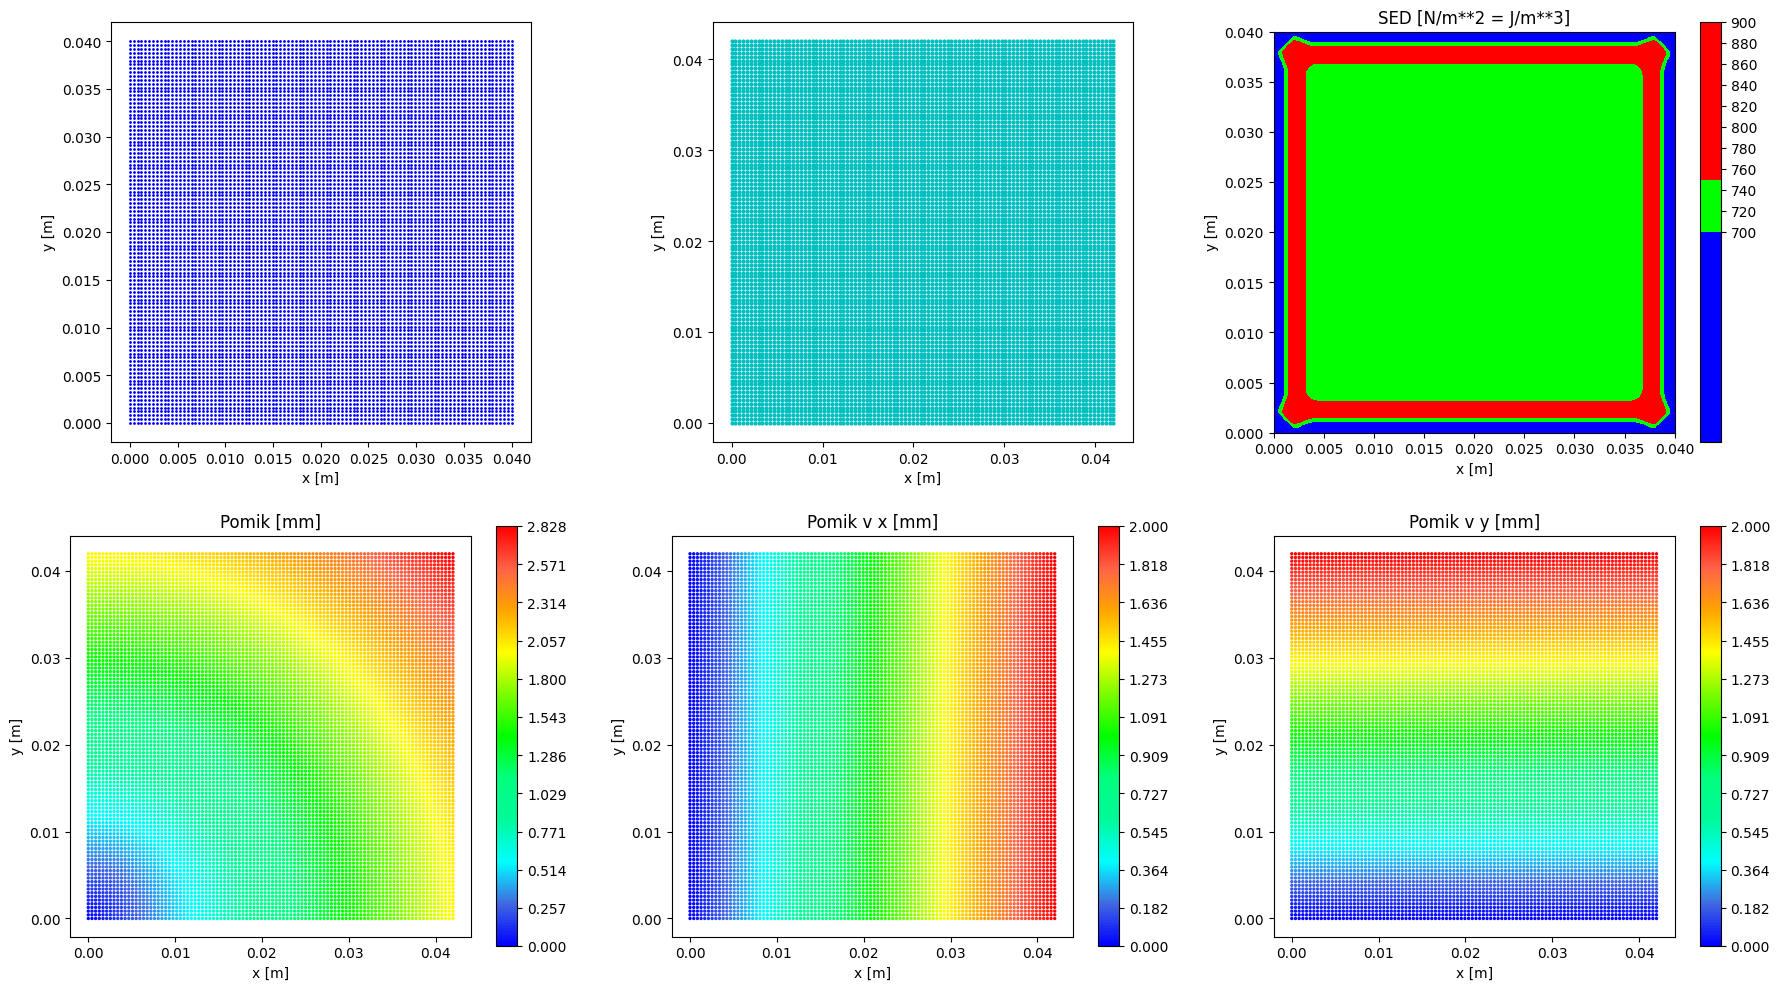

In [120]:
s = 2
#mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["blue","royalblue","cyan","mediumspringgreen","springgreen","lime","lawngreen","yellow","orange","tomato","red"],N=11)
mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["blue","royalblue","cyan","mediumspringgreen","springgreen","lime","lawngreen","yellow","orange","tomato","red"])
#mycmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom",["blue","cyan","green","yellow","orange","red"])
fig1 = plt.figure(figsize=(22,12))

## Nedeformirana oblika
ax0 = fig1.add_subplot(2,3,1)
# ax0.plot(coordVec[:,0],coordVec[:totint,1],'co',markersize=1)
# ax0.plot(coordVec[totint:totbottom,0],coordVec[totint:totbottom,1],"ro",markersize=1)
ax0.plot(coordVec[:,0],coordVec[:,1],"bo",markersize=1)
ax0.set_aspect("1")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

##Deformirana oblika
ax1 = fig1.add_subplot(2,3,2)
ax1.plot(coordVecNew4[:,0],coordVecNew4[:,1],'co',markersize=s)
# ax1.plot(coordVecNew4[:,0],coordVecNew4[:,1],"ro",markersize=s)
# ax1.plot(coordVecNew4[:,0],coordVecNew4[:,1],"bo",markersize=s)
ax1.set_aspect("1")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

##Strain energy density
ax5 = fig1.add_subplot(2,3,3)
sc5 = ax5.tricontourf(coordVec[:,0],coordVec[:,1],point_SED/1e6,cmap=mycmap,vmin = 700, vmax =750)#,c=point_SED)

# ax5.set_ylim(0.015,0.025)
ax5.set_aspect("1")
plt.title("SED [N/m**2 = J/m**3]")
plt.colorbar(sc5,ticks = [700 + i*20 for i in range(20) ])
plt.xlabel("x [m]")
plt.ylabel("y [m]")

## Absolutni pomiki
ax2 = fig1.add_subplot(2,3,4)
ax2.set_aspect("1")
#h = np.sqrt(disp[:,0]*disp[:totint,0]+disp[:totint,1]*disp[:totint,1])*1000
h = np.sqrt(disp[:,0]*disp[:,0]+disp[:,1]*disp[:,1])*1000
cm = plt.cm.get_cmap('RdYlBu')
#sc = ax.scatter(coordVecNew4[:totint,0],coordVecNew4[:totint,1],s=s,c=h,cmap=mycmap)
#p1=coordVec[:totint,0].reshape(100,100)
#p2=coordVec[:totint,1].reshape(100,100)
#sc = ax.contourf(p1,p2,h.reshape(100,100),cmap=mycmap)
sc = ax2.scatter(coordVecNew4[:,0],coordVecNew4[:,1],s=s,c=h[:],cmap=mycmap)
#sc3 = ax.scatter(coordVecNew4[totbottom:tottop,0],coordVecNew4[totbottom:tottop,1],s=s,c=h[totbottom:tottop],cmap=mycmap)

plt.title("Pomik [mm]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
v= np.linspace(np.min(h),np.max(h),12,endpoint=True)
plt.colorbar(sc,ticks=v)

##Pomiki X
ax3 = fig1.add_subplot(2,3,5)
ax3.set_aspect("1")
# h1 = disp[:totint,0]*1000
h1 = disp[:tottop,0]*1000
vm=h1#np.max(disp[:tottop,0])
cm1 = plt.cm.get_cmap('RdYlBu')
sc1 = ax3.scatter(coordVecNew4[:,0],coordVecNew4[:,1],s=s,c=h1[:],cmap=mycmap)
plt.title("Pomik v x [mm]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
v1= np.linspace(np.min(h1),np.max(h1),12,endpoint=True)
plt.colorbar(sc1,ticks=v1)

##Pomiki Y
ax4 = fig1.add_subplot(2,3,6)
ax4.set_aspect("1")
h2 = disp[:,1]*1000
cm2 = plt.cm.get_cmap('RdYlBu')
#sc2 = plt.scatter(coordVecNew4[:,0],coordVecNew4[:,1],s=s,c=h2[:],cmap=mycmap)
sc2 = plt.scatter(coordVecNew4[:,0],coordVecNew4[:,1],s=s,c=h2[:],cmap=mycmap)
plt.title("Pomik v y [mm]")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
v2= np.linspace(np.min(h2),np.max(h2),12,endpoint=True)
plt.colorbar(sc2,ticks=v2)

In [97]:
force_dens_vecs[:17]

array([[6.06530455e+18, 0.00000000e+00],
       [5.84405745e+18, 0.00000000e+00],
       [5.47488506e+18, 0.00000000e+00],
       [5.05427360e+18, 0.00000000e+00],
       [4.69224645e+18, 0.00000000e+00],
       [4.58949478e+18, 0.00000000e+00],
       [0.00000000e+00, 6.06530455e+18],
       [4.48935005e+18, 4.48935005e+18],
       [4.95892207e+18, 2.85061733e+18],
       [4.82243549e+18, 1.90064273e+18],
       [4.56322230e+18, 1.39147644e+18],
       [4.31111550e+18, 1.09931195e+18],
       [0.00000000e+00, 5.84405745e+18],
       [2.85061733e+18, 4.95892207e+18],
       [3.95216816e+18, 3.95216816e+18],
       [4.20564792e+18, 3.02764794e+18],
       [4.17182976e+18, 2.37844944e+18]])

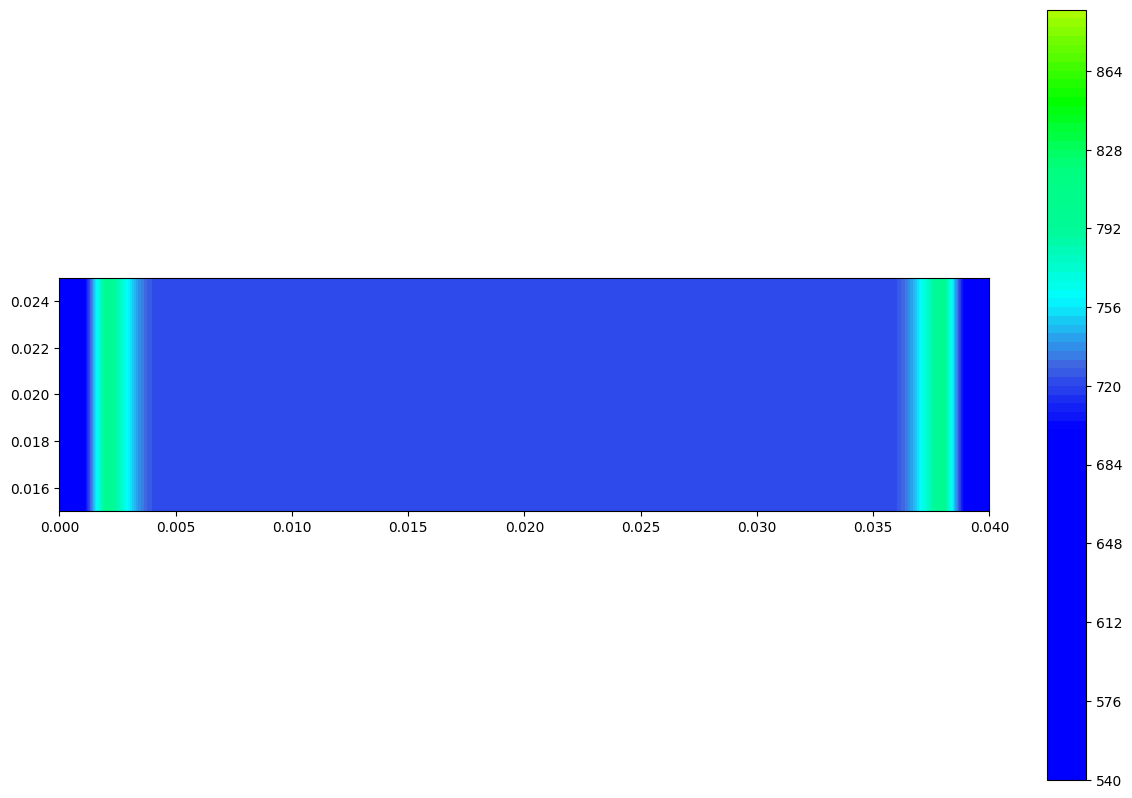

In [98]:
fig = plt.figure(figsize=(15,10))
axs = fig.add_subplot()
cont =axs.tricontourf(coordVec[:,0],coordVec[:,1],point_SED/1e6, levels=100,cmap=mycmap,vmin=700,vmax=1000)
# cont =axs.scatter(coordVec[:,0],coordVec[:,1],c=point_SED,cmap=mycmap,vmin=4700,vmax=6300)
axs.set_ylim(0.015,0.025)
axs.set_aspect(1)
plt.colorbar(cont)

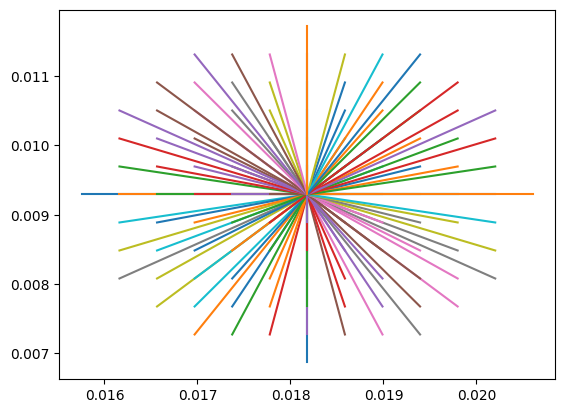

In [99]:
pnt = 2345
for bond in range(coordVec[solver.FID.neighbors[solver.FID.start_idx[pnt]:solver.FID.end_idx[pnt]]].shape[0]):
    y2 = coordVec[solver.FID.neighbors[solver.FID.start_idx[pnt]:solver.FID.end_idx[pnt]]][bond][1]
    x2 = coordVec[solver.FID.neighbors[solver.FID.start_idx[pnt]:solver.FID.end_idx[pnt]]][bond][0]
    x1 = coordVec[pnt][0]
    y1 = coordVec[pnt][1]
    
    plt.plot([x1,x2],[y1,y2])

In [100]:
c = lambda E,delta,h: 24/(np.pi*h*delta**3) *(E/(float(1-0.25)))
f = lambda cc,s,n0,n1: cc*s * np.array((n0,n1))

In [101]:
cc = c(180000,6*dx,1)
cc,f(cc,0.05,1,0)

(128689901772602.47, array([6.43449509e+12, 0.00000000e+00]))

In [102]:
((24*180000*(0.05**2)*dx*6)/(np.pi *(6*dx)**3* (1-0.25))/2)/10e7

3.8996939931091665